In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from IPython.display import clear_output
from os.path import join
from enum import Enum

import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm, trange

from google.colab import drive
drive.mount('/content/gdrive')

%cd /content/gdrive/MyDrive/repos_test
if not 'Fi' in locals():
    %cd src
    from MathUtils import *
    %cd /content

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/repos_test
/content/gdrive/MyDrive/repos_test/src
/content


In [2]:
%pip install timm lightning torchmetrics tbparse
!python3 -m pip install git+https://github.com/lessw2020/Ranger21.git
clear_output()

import timm
import ranger21
import torchmetrics
import lightning as L
from tbparse import SummaryReader
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

In [3]:
# функция XSigmoidLoss. Взято из
# https://github.com/tuantle/regression-losses-pytorch
class XSigmoidLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, y_t, y_prime_t):
        ey_t = y_t - y_prime_t
        return torch.mean(2 * ey_t / (1 + torch.exp(-ey_t)) - ey_t)

# Датасет, который хранит всю обучающую выборку в оперативной памяти
# Сейчас не используется
class MyDataSet(Dataset):
    def __init__(self,X_files,noise_std=0.0,norm=1,bin=False,max_value=16383):
        t0 = time()

        one_size = 500
        self.noise_std = noise_std
        N = len(X_files)

        self.images = np.zeros((one_size * N, 1, 184, 184))
        self.labels = np.zeros((one_size * N, 18))

        for i, fn in enumerate(X_files):
          self.images[i * one_size : (i + 1) * one_size] = np.load(X_files[i])
          self.labels[i * one_size : (i + 1) * one_size] = np.load(X_files[i].replace('images', 'labels'))


        total_dim=int(self.labels.size/self.labels.shape[-1])

        self.images=self.images.reshape(total_dim,self.images.shape[-1],self.images.shape[-1])
        self.labels=self.labels.reshape(total_dim,self.labels.shape[-1])

        for i in range(len(self.images)):
          self.labels[i]/=norm

        self.images=self.images[:,None,:,:]

        self.images=self.images.astype('float32')

        print(self.images.shape)
        print(np.max(self.images))
        for i in range(len(self.images)):
            self.images[i]/=np.max(self.images[i])

        self.labels=self.labels.astype('float32')

        self.images=torch.FloatTensor(self.images)
        self.labels=torch.FloatTensor(self.labels)

        self.transform = torchvision.transforms.Lambda(lambda x : x + self.noise_std * torch.randn(1, 184, 184).abs())


    def __len__(self):
        return len(self.images)


    def __getitem__(self,idx=0):

        return self.transform(self.images[idx]), self.labels[idx]


In [4]:
# Выбор, откуда загружать изображения
class MODE(Enum):
  POS = 0 # за линзой
  NEG = 1 # перед линзой
  BOTH = 2 # с обеих позиций

# Датасет, который подгружает файлы с диска
class ImgDataset(Dataset):
  def __init__(self, path, mode, idx_start = 0, idx_end = -1,\
               transform = None, norm = 1, atan_labels = True):
    self.path = path
    self.idx_start = idx_start
    self.idx_end = idx_end


    self.labels = np.load(join(self.path, f'y.npy'))[self.idx_start:self.idx_end]

    self.labels = self.labels / norm
    self.labels = torch.Tensor(self.labels)
    if atan_labels:
      self.labels = self.labels.arctanh()

    self.path = join(path, 'X')
    self.files = os.listdir(self.path)[idx_start:idx_end]


    for i in range(len(self.files)):
        self.files[i] = join(self.path, self.files[i])
    self.transform = transform

    if mode == MODE.POS:
      self.image_idx = slice(0, 1)
    elif mode == MODE.NEG:
      self.image_idx = slice(1, 2)
    else:
      self.image_idx = slice(0, 2)

  def __len__(self):
    return len(self.labels)
  def __getitem__(self, idx):
    X = np.load(join(self.path, f'{idx + self.idx_start}.npy'), allow_pickle = False)
    X = torch.Tensor(X)
    if self.transform != None:
      X = self.transform(X)
    X = X[self.image_idx, :, :]
    return X, self.labels[idx]

  def calculate_moments(self, eps = 0.0):
    self.eps = eps
    self.mean = 0.0
    self.std = 0.0
    N = len(self.files)

    for i in range(len(self.files)):
      X, _ = self[i]
      nz = (X > self.eps)

      self.mean += (nz * X).sum(axis = (1, 2)) / nz.sum(axis = (1, 2))
    self.mean /= N

    for file in self.files:
      X, _ = self[i]
      nz = (X > self.eps)
      self.std += (nz * (X - self.mean[:, None, None]) ** 2).sum(axis = (1, 2)) / nz.sum(axis = (1, 2))
    self.std = (self.std  / N) ** 0.5

In [53]:
!unzip -q gdrive/MyDrive/ds5pn_30k.zip -d dataset

unzip:  cannot find or open gdrive/MyDrive/ds5pn_30k.zip, gdrive/MyDrive/ds5pn_30k.zip.zip or gdrive/MyDrive/ds5pn_30k.zip.ZIP.


In [59]:
norm = np.ones(18) * 1.0
norm[[0, 1, 2]] = 10
norm[[4, 5]] = 7
norm[[9]] = 3

transform = SparseNormilize(mean = [0.1108, 0.1246],
                    std = [0.1538, 0.1634],
                    eps = 1e-2)

In [14]:
trn_ds = ImgDataset('dataset/dataset/', idx_start = 0, idx_end = 28000, transform = transform, \
                    norm = norm, mode = MODE.BOTH)
val_ds = ImgDataset('dataset/dataset/', idx_start = 28000, idx_end = 30000, transform = transform, \
                    norm = norm, mode = MODE.BOTH)

In [ ]:
# расчёт среднего и стандартного отклонения
# Закомментировано, так как это долго

# trn_ds.calculate_moments(eps = 1e-2)

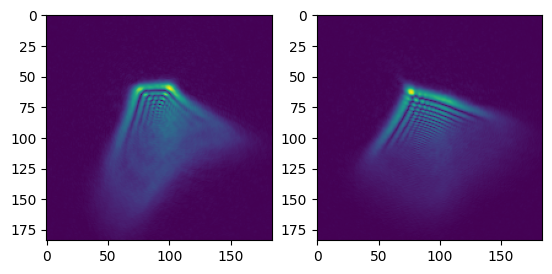

In [ ]:
X, y = trn_ds[2]
fig,axs = plt.subplots(1,2)
axs[0].imshow(X[0])
axs[1].imshow(X[1])

In [ ]:
class Lit(L.LightningModule):
  def __init__(self, model,
               exp_name = 'baseline',\
               other_params = {},\
               crit = nn.MSELoss(), opt_class = optim.AdamW,\
               opt_kwargs = {'lr' : 1e-3},\
               metric_class = torchmetrics.MeanSquaredError,
               metric_kwargs = {}):
    super().__init__()


    self.model = model
    self.criterion = crit
    self.opt_class = opt_class
    self.opt_kwargs = opt_kwargs

    self.trn_metric = metric_class(**metric_kwargs)
    self.val_metric = metric_class(**metric_kwargs)



  def configure_optimizers(self):
    optimizer = self.opt_class(self.model.parameters(), **self.opt_kwargs)
    return optimizer


  def training_step(self, batch, batch_idx):
    X, y = batch
    y_pred = self.model(X)
    loss = self.criterion(y_pred, y)

    self.trn_metric.update(y_pred.cpu(), y.cpu())
    self.log('trn_loss', loss.detach().item())

    return loss


  def validation_step(self, batch, batch_idx):
    X, y = batch
    with torch.no_grad():
      y_pred = self.model(X)
      loss = self.criterion(y_pred, y)

    self.val_metric.update(y_pred.cpu(), y.cpu())
    self.log('val_loss', loss.detach().item())

    return loss


  def on_train_epoch_end(self):
    m = self.trn_metric.compute()
    print('trn:', m)
    self.log('trn_metric', m)
    self.trn_metric.reset()


  def on_validation_epoch_end(self):
    m = self.val_metric.compute()
    print('val:', m)
    self.log('val_metric', m)
    self.val_metric.reset()

In [ ]:
loaders={'trn' : DataLoader(trn_ds, batch_size = 16, shuffle = True, num_workers = 3),\
         'val' : DataLoader(val_ds, batch_size = 16, shuffle = False, num_workers = 3)}

In [ ]:
print(*timm.list_models('*convformer*',pretrained = True), sep = '\n')

convformer_b36.sail_in1k
convformer_b36.sail_in1k_384
convformer_b36.sail_in22k
convformer_b36.sail_in22k_ft_in1k
convformer_b36.sail_in22k_ft_in1k_384
convformer_m36.sail_in1k
convformer_m36.sail_in1k_384
convformer_m36.sail_in22k
convformer_m36.sail_in22k_ft_in1k
convformer_m36.sail_in22k_ft_in1k_384
convformer_s18.sail_in1k
convformer_s18.sail_in1k_384
convformer_s18.sail_in22k
convformer_s18.sail_in22k_ft_in1k
convformer_s18.sail_in22k_ft_in1k_384
convformer_s36.sail_in1k
convformer_s36.sail_in1k_384
convformer_s36.sail_in22k
convformer_s36.sail_in22k_ft_in1k
convformer_s36.sail_in22k_ft_in1k_384


In [133]:
model = timm.create_model('convformer_s18.sail_in22k_ft_in1k',\
                          pretrained = True, in_chans = 2)
model.head.fc.fc2 = nn.Linear(in_features = 2048, out_features = 18)

# model.load_state_dict(torch.load('cof18_ds5neg_28k'))

In [ ]:
checkpoint_callback = ModelCheckpoint(monitor = "val_metric")
num_epochs = 20

lit_model = Lit(model, opt_class = ranger21.Ranger21,\
                opt_kwargs = {'lr' : 1e-3, 'num_epochs' : num_epochs,\
                      'num_batches_per_epoch' : len(loaders['trn']),
                    'use_warmup' : False, 'warmdown_active' : False,
                                                },\
                crit = XSigmoidLoss())
model_name = 'ConvFormerS18_ds5neg_+5ep_1'
trainer = L.Trainer(max_epochs = num_epochs,\
                    logger = TensorBoardLogger(save_dir = f"lightning_logs/{model_name}"),\
                    log_every_n_steps = 5)
                    # callbacks=[checkpoint_callback])
trainer.fit(model = lit_model,\
            train_dataloaders = loaders['trn'],\
            val_dataloaders = loaders['val'])

In [ ]:
reader = SummaryReader(trainer.logger.experiment.get_logdir(), pivot = True)
df = reader.scalars
df.head()

,step,epoch,trn_loss,trn_metric,val_loss,val_metric
0,4,0.0,0.000043,NaN,NaN,NaN
1,9,0.0,0.000032,NaN,NaN,NaN
2,14,0.0,0.000041,NaN,NaN,NaN
3,19,0.0,0.000038,NaN,NaN,NaN
4,24,0.0,0.000045,NaN,NaN,NaN


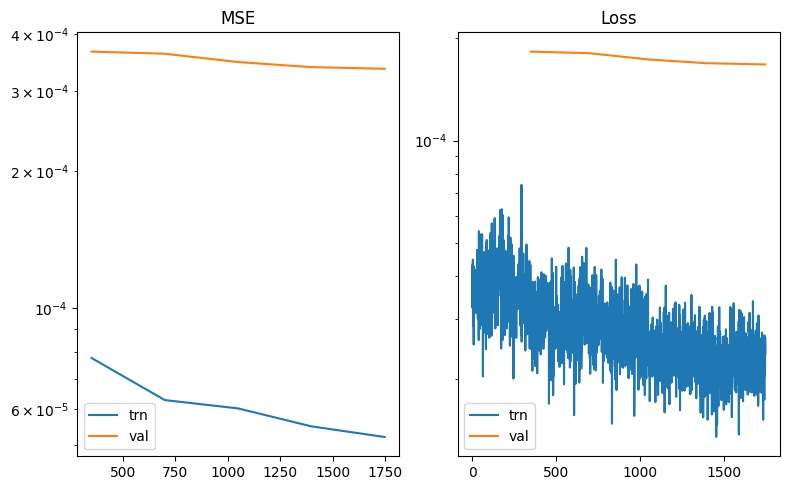

In [ ]:
fig = plt.figure(figsize = (8, 5))

def drop_nan(df, tag):
    return df[~df[tag].isna()].loc[:, tag]

fig = plt.subplot(1, 2, 1)
plt.title('MSE')
plt.plot(drop_nan(df, tag = 'trn_metric'), label = 'trn')
plt.plot(drop_nan(df, tag = 'val_metric'), label = 'val')
plt.legend(loc = 'best')
plt.yscale('log')

fig=plt.subplot(1, 2, 2)
plt.title('Loss')
plt.plot(drop_nan(df, tag='trn_loss'), label = 'trn')
plt.plot(drop_nan(df, tag='val_loss'), label = 'val')
plt.legend(loc = 'best')
plt.yscale('log')

plt.tight_layout()
plt.show()

In [ ]:
df.to_csv('cof18_ds5neg_28k_lr=1e-4_+5ep.csv')

In [ ]:
model = trainer.model.model
torch.save(model.state_dict(), 'cof18_ds5posneg_28k_+5ep.csv')

In [134]:
%cd /content/gdrive/MyDrive/repos_test

model.load_state_dict(torch.load('weights/cof18_ds5both_28k'))
# model.load_state_dict(torch.load('/content/gdrive/MyDrive/машинка/Experiment2/models/cof18_ds5neg_28k_(1)'))#, map_location = 'cpu'))
model = model.cuda()

/content/gdrive/MyDrive/repos_test


In [135]:
tst_ds = ImgDataset('/content/dataset2/content/test_dataset', norm = norm,\
                    transform = transform, mode = MODE.BOTH)

In [136]:
mse = np.zeros(18)
model.eval()

# try:
for X, y in tqdm(tst_ds):
    with torch.no_grad():
        y_pred = model(X[None, :, :, :].cuda())
        y_pred = y_pred.detach().flatten().cpu()

        mse += ((y.tanh() - y_pred.tanh()) ** 2).numpy()


mse /= len(tst_ds)


100%|██████████| 1999/1999 [00:32<00:00, 61.63it/s]


In [139]:
# plt.plot(list_)
print(np.mean(mse)) # в условных единицах

0.00019523523571463128


In [138]:
# RMS ошибка на тесововм сете в длинах волн
rms = mse ** 0.5 / 2 / np.pi
np.mean(mse * norm ** 2)** 0.5 / 2 / np.pi

0.0057726587562011

In [121]:
# выще приведены ошибка на тестовом сете модели cof18_28k_both из папки weights

1.5277777777777777